# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import copy

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

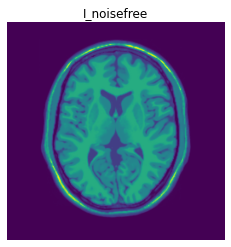

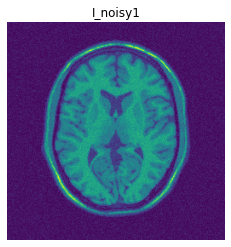

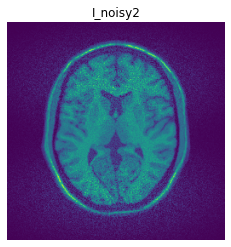

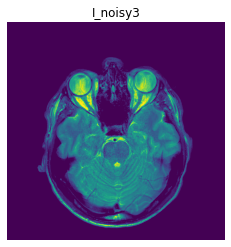

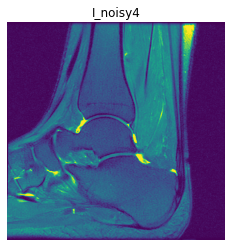

In [2]:
mat = loadmat('MR_data.mat')
images_str = ['I_noisefree', 'I_noisy1', 'I_noisy2', 'I_noisy3', 'I_noisy4']
for image in images_str:
    plt.imshow(mat[image]), plt.title(image), plt.axis('off'), plt.show()

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [3]:
def gaussian_space(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g / g.sum() 
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()

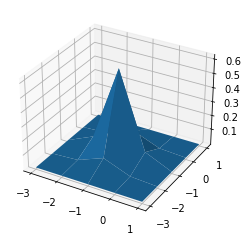

In [4]:
mesh(gaussian_space(size=5, sigma=0.5), size=5)

In [5]:
def classic_convolution(img, mask_size, sigma):
    (Y, X) = img.shape
    I = copy.deepcopy(img)
    if mask_size % 2 == 0:
        mask_size -= 1
    mask = gaussian_space(mask_size, sigma)
    
    for y in range(Y-mask_size):
        for x in range(X-mask_size):
            mid_y = (2*y + mask_size) // 2
            mid_x = (2*x + mask_size) // 2
            I[mid_y, mid_x] = np.sum(mask * img[y:y+mask_size, x:x+mask_size])
    
    return I

def plot_classic_convolution(image_str, mask_size, sigma):
    I_ = classic_convolution(mat[image_str], mask_size, sigma)
    if mask_size % 2 == 0:
        mask_size -= 1
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(mat[image_str]), ax[0].set_title(image_str), ax[0].axis('off')
    ax[1].imshow(I_), 
    ax[1].set_title('after classic convolution\nwith mask_size={} and sigma={}'.format(mask_size, sigma)) 
    ax[1].axis('off')
    plt.show()

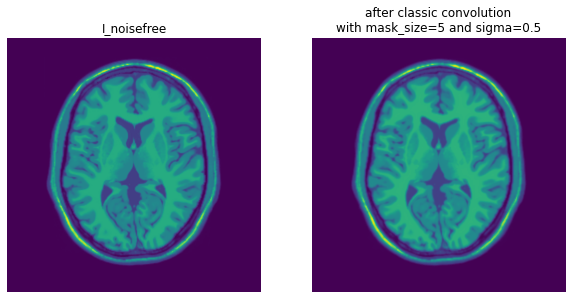

In [6]:
plot_classic_convolution(images_str[0], 5, 0.5)

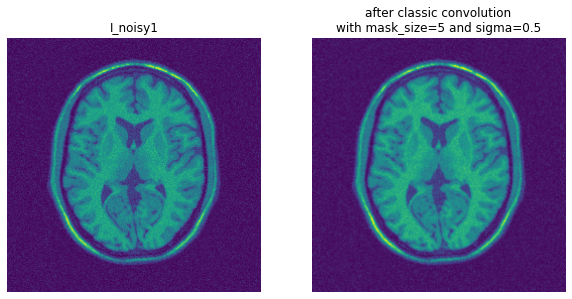

In [7]:
plot_classic_convolution(images_str[1], 5, 0.5)

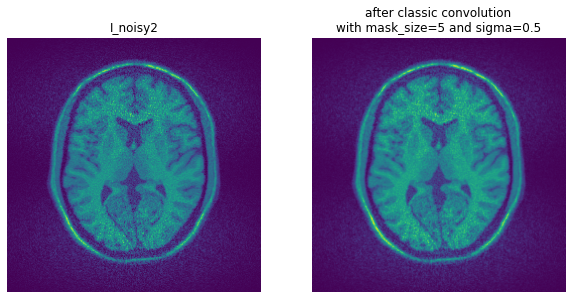

In [8]:
plot_classic_convolution(images_str[2], 5, 0.5)

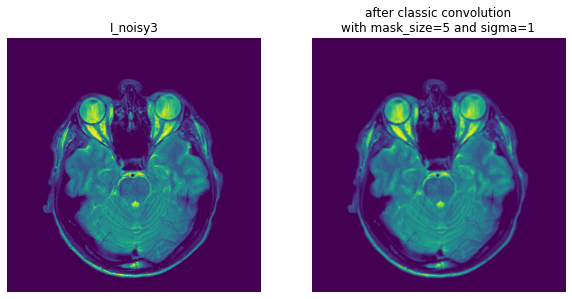

In [9]:
plot_classic_convolution(images_str[3], 5, 1)

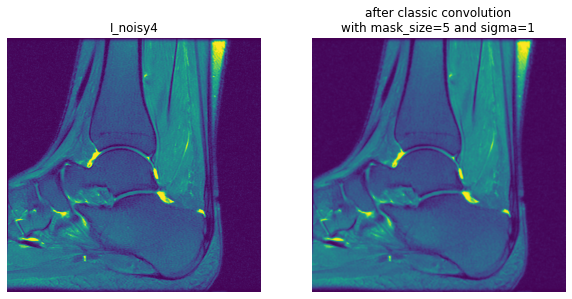

In [10]:
plot_classic_convolution(images_str[4], 5, 1)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [11]:
def gaussian_range(I, size, sigma_r):
    range_matrix = np.zeros((size, size))
    mid = size//2
    for y in range(size):
        for x in range(size):
            range_matrix[y, x] = np.exp(-((I[y,x]-I[mid,mid].astype(float))**2/(2*sigma_r**2)))
    range_matrix = range_matrix / np.sum(range_matrix) * size**2
    return range_matrix

def bilateral_filtering(img, mask_size, sigma_s, sigma_r):
    (Y, X) = img.shape
    I = copy.deepcopy(img)
    if mask_size % 2 == 0:
        mask_size -= 1
    
    for y in range(Y-mask_size):
        for x in range(X-mask_size):
            mid_y = (2*y + mask_size) // 2
            mid_x = (2*x + mask_size) // 2
            window = img[y:y+mask_size, x:x+mask_size]
            space_weight = gaussian_space(mask_size, sigma_s)
            range_weight = gaussian_range(window, mask_size, sigma_r)
            I[mid_y, mid_x] = np.sum(window * space_weight * range_weight)
            
    return I

def plot_bilateral_filtering(image_str, mask_size, sigma, sigma_s, sigma_r):
    I1 = classic_convolution(mat[image_str], mask_size, sigma)
    I2 = bilateral_filtering(mat[image_str], mask_size, sigma_s, sigma_r)
    if mask_size % 2 == 0:
        mask_size -= 1
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].imshow(mat[image_str]), ax[0].set_title(image_str)
    ax[1].imshow(I1) 
    ax[1].set_title('after classic convolution with\nmask_size={} and sigma={}'.format(mask_size, sigma)) 
    ax[2].imshow(I2) 
    ax[2].set_title('after bilateral filtering with\nmask_size={}, sigma_s={}, sigma_r={}'.format(mask_size, sigma_s, sigma_r))
    for i in range(3):
        ax[i].axis('off')
    plt.show()

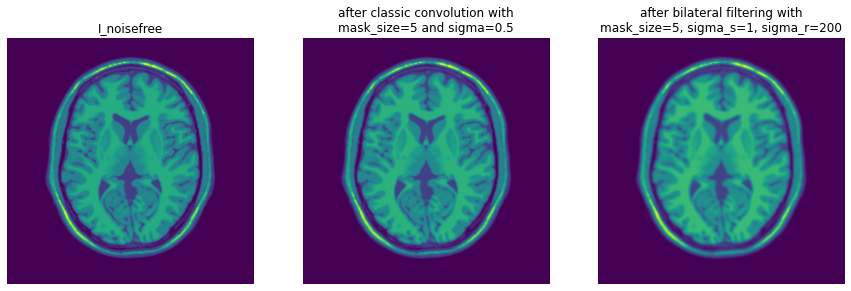

In [12]:
plot_bilateral_filtering(images_str[0], 5, 0.5, 1, 200)

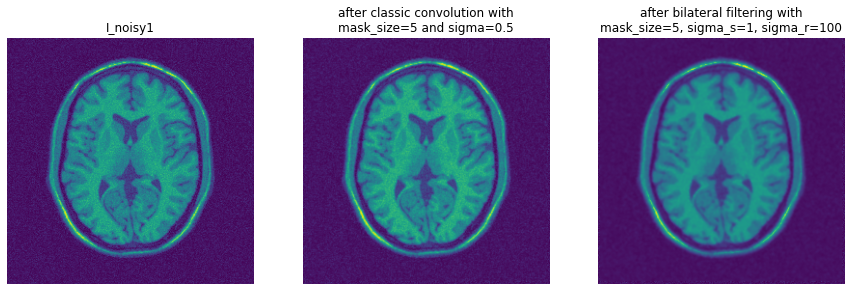

In [13]:
plot_bilateral_filtering(images_str[1], 5, 0.5, 1, 100)

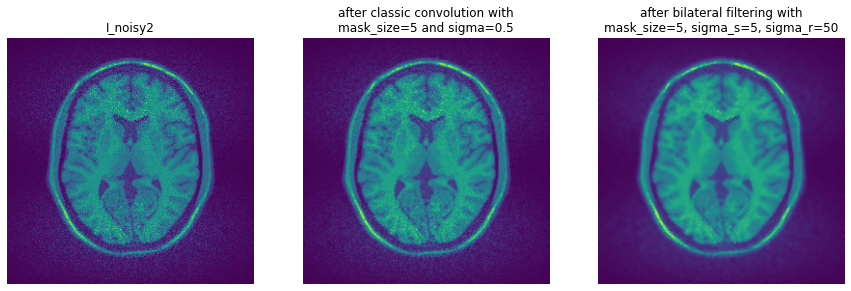

In [14]:
plot_bilateral_filtering(images_str[2], 5, 0.5, 5, 50)

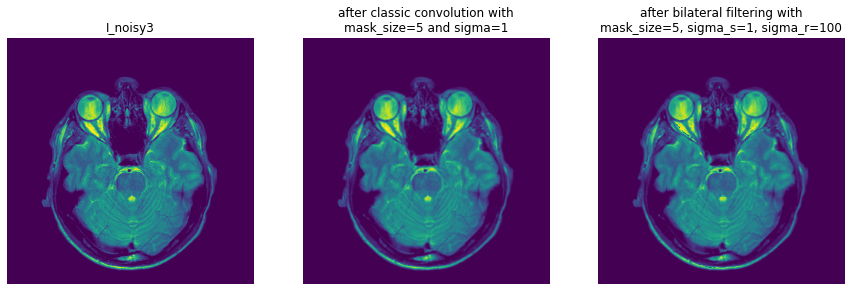

In [15]:
plot_bilateral_filtering(images_str[3], 5, 1, 1, 100)

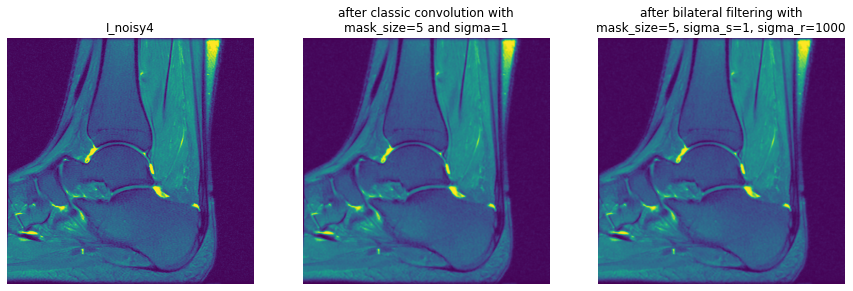

In [16]:
plot_bilateral_filtering(images_str[4], 5, 1, 1, 1000)